In [1]:
import sys

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn
import pandas as pd

In [2]:
class emailData():
    def __init__(self, df):
        
        if df.columns.values[0] == 'time':
            self.transformed_df = df
        
        else:
            self.transformed_df = self._reformat_dataframe(df)
        
        
        self.all_names, self.senders, self.receivers, self.individual_emails = self.get_all_name_list(self.transformed_df)
        self.counts_df = self.name_aggregate_counts(self.transformed_df)
        self.prolific_senders = self.get_prolific_senders(self.counts_df, 20)
        self.current_time_ag = [self.transformed_df]
        
    def _reformat_dataframe(self, df):
        '''This function takes in the original dataframe and puts it into a more usable format 
           (what I call a transformed dataframe).  Time is in days.'''
        headers = ['time', 'messageid', 'sender', 'recipients', 'topic', 'mode']
        df.columns = headers
        df.drop(['topic', 'mode'], axis = 1, inplace = True)
        df.recipients = df.recipients.astype(str)
        df.recipients = df.recipients.apply(split_emails)
        df.time = (df.time - df.time.min())/(1000*60*60*24)
    
        return df
    
    def get_all_name_list(self, df):
        '''This function takes in a transformed dataframe and returns a list of all names as well as just sender and recipients.
           Also the original df has multiple recipients in one row so I make a list of the form [[sender, receiver1], [sender, receiver2]]'''
        
        sender_names = df.sender.values
        recipient_lists = df.recipients.values

        individual_emails = np.array([[sender_names[i], recipi] for i in xrange(len(recipient_lists)) for recipi in recipient_lists[i]])
        
        sender_names = list(set(sender_names))
        recipient_names = list(set([item for sublist in recipient_lists for item in sublist]))
        
        return list(set(sender_names + recipient_names)), sender_names, recipient_names, individual_emails
    
    def name_aggregate_counts(self, df):
        ''' Here I'm doing counts grouped by name. (hence name_aggregate)'''
        sender_names = list(df.sender.values)
        recipient_lists = df.recipients.values

        recipient_names = [item for sublist in recipient_lists for item in sublist]
   
        recipient_series = pd.Series(recipient_names)
        recp_counts = recipient_series.value_counts()
        send_counts = df.sender.value_counts()
        
        countdf = pd.DataFrame(self.all_names, columns = ['person'], index = self.all_names)
    
        countdf['sent'] = send_counts
        countdf['received'] = recp_counts
        countdf.names = countdf.person.astype(str)
        countdf = countdf.fillna(0)

        countdf.sent = countdf.sent.astype(int)
        countdf.received = countdf.received.astype(int)
    
        countdf.sort_values('sent',  ascending=False, inplace=True)
        return countdf
    
    def time_aggregate(self, start_date, end_date, num_days):
        ''' Here I partition a transformed data frame between start_date (in days) and end_date (in days).
            num_days is the number of days that is in each partition'''
        num_partitions = np.ceil((end_date - start_date)/num_days) + 1

        df = start_end_sep(self.transformed_df, start_date, end_date)

        times = np.linspace(start_date, end_date, num_partitions)
        sub_data = [start_end_sep(df, times[i], times[i+1]) for i in xrange(len(times)-1)]

        self.current_time_ag = sub_data
        return sub_data
    
    def name_time_aggregate(self, start_date, end_date, num_days):
        ''' This combines the last two functions an breaks down the df into other dfs by time
            and then performs sent-received counts on each of those dfs.'''
        sub_data = self.time_aggregate(start_date, end_date, num_days)
        return [self.name_aggregate_counts(data) for data in sub_data]

    def get_prolific_senders(self, counts_df, num_std):
        ''' The class has a method to get prolific senders based on whether they emailed some number of standard deviations
            above the mean'''
        std_sent = self.counts_df.sent.std()
        mean_sent = self.counts_df.sent.mean()
        return self.counts_df.person[self.counts_df.sent > num_std*std_sent + mean_sent].values
    


In [3]:
def start_end_sep(df, start, end):
    '''just a function to return the data from the specified time period'''
    return df[(df.time >= start) & (df.time<= end)]
    
def get_senders_set(individual_emails, name):
    '''find the unique people who sent emails to name.  individual_emails list as referred to in comment in class '''
    
    try: 
        if len(individual_emails)>0:
        
            return list(set(individual_emails[:,0][individual_emails[:,1]==name]))
        else: 
            
            return []
    except:
        return individual_emails 
    
def get_receivers_set(individual_emails, name):
    '''find the unique people who received emails from name.  individual_emails list as referred to in comment in class '''
    try:
        if len(individual_emails)>0:
            return list(set(individual_emails[:,1][individual_emails[:,0]==name]))
        else:
            return []
    except:
        return individual_emails
        
        
def split_emails(val):
    '''just a helper function for transforming'''
        return val.split('|')
    
def get_individual_emails(df):
    sender_names = df.sender.values
    recipient_lists = df.recipients.values
    return np.array([[sender_names[i], recipi] for i in xrange(len(recipient_lists)) for recipi in recipient_lists[i]])
     
def get_unique_sent_received_counts(individual_emails, names_list):

    received_from = [len(get_senders_set(individual_emails, name)) for name in names_list]
    sent_to = [len(get_receivers_set(individual_emails, name)) for name in names_list]

    return pd.DataFrame(np.array([names_list, sent_to, received_from]).T, columns = ['person', 'unique_sent_to', 'unique_received_from'])



In [4]:
base_dir = './'
fn = 'enron-event-history-all.csv'
df = pd.read_csv(base_dir + fn, header = None)
eData = emailData(df)
eData.counts_df.to_csv('part1.csv', index = False)

In [5]:
num_days = 14
nt_ag = eData.name_time_aggregate(min(eData.transformed_df.time.values), max(eData.transformed_df.time.values), num_days)
prolific = [table[table.person.isin(eData.prolific_senders)] for table in nt_ag]
data_to_plot = [[table[table.person == person].sent.values[0] for table in prolific] for person in eData.prolific_senders]
cumulative = [[np.array(data[:i]).sum() for i in xrange(len(data_to_plot[0])-1) ]for data in data_to_plot]

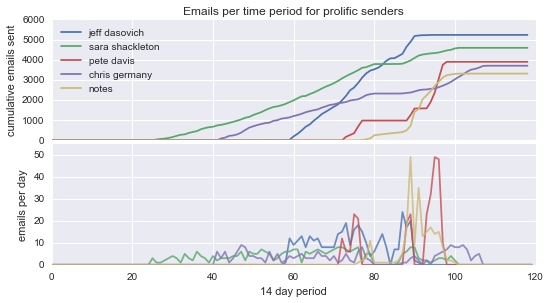

In [6]:
num_to_plot = 5
fig = plt.figure(figsize = (1.2*8,1.2*4))
axis1 = fig.add_axes([0.15, 0.14, 0.7, 0.35])
axis2 = fig.add_axes([0.15, 0.5, 0.7, 0.35])
for i in xrange(num_to_plot):
    plt.sca(axis1)
    plt.plot(np.array(data_to_plot[i])/num_days,'-', label = eData.prolific_senders[i], alpha = 0.8)
    plt.sca(axis2)
    plt.plot(cumulative[i], label = eData.prolific_senders[i])
plt.sca(axis1)

plt.xlabel('%0d day period'%num_days)
plt.ylabel('emails per day')

plt.ylim(0, 55)

plt.sca(axis2)
plt.ylabel('cumulative emails sent')
plt.legend(loc = 2)
axis2.set_xticklabels([])

plt.title('Emails per time period for prolific senders')

plt.savefig('part2.png')


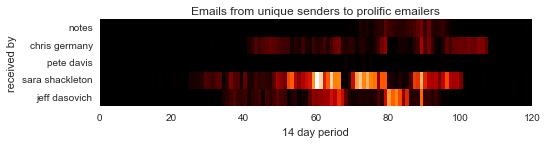

In [7]:
rfrom = []
names_list = eData.prolific_senders[:num_to_plot]

for k in xrange(len(eData.current_time_ag)):
    ie = get_individual_emails(eData.current_time_ag[k])
    rfrom.append(get_unique_sent_received_counts(ie, names_list).unique_received_from.values)
    
rfrom = np.array(rfrom, dtype = int)

fig = plt.figure(figsize = (8,2))
ax = fig.add_axes([0.2, 0.25, 0.75, 0.6])
ax.pcolormesh(rfrom.T, cmap='gist_heat')
plt.yticks(np.array(range(len(names_list)), dtype = float) + 0.5)
ax.set_yticklabels(names_list)
plt.xlabel('%0d day period'%num_days)
plt.ylabel('received by')
plt.title('Emails from unique senders to prolific emailers')
plt.savefig('part3.png')